# Model Creation: Round 2


#### Importing the necessary libraries

In [11]:
import next_pitch
from next_pitch import library
from next_pitch import pitch_functions

In [12]:
from next_pitch.pitch_functions import run_classifier_models, roc_auc_score, calc_acc_and_f1_score

In [13]:
#DATA WRANGLING
import pandas as pd # Dataframes
from pandas.io.json import json_normalize # JSON wrangler
import statsapi # Python wrapper MLB data API

In [14]:
#DATA MANIPULATION AND MODELLING
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn_pandas import DataFrameMapper, FunctionTransformer, gen_features, pipeline
from sklearn_pandas.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import xgboost as xgb
import os
# import pitch_functions

In [15]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load Data

In [16]:
each_pitch = pd.read_csv('raw_data/final_pitches.csv')

In [17]:
test_pitch = pd.read_csv('raw_data/cleaned_pitches1.csv')

In [18]:
test_pitch = test_pitch.fillna(value=0)


In [19]:
test_pitch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
about.atBatIndex            200 non-null int64
about.halfInning            200 non-null object
about.inning                200 non-null int64
details.call.description    200 non-null object
details.description         200 non-null object
matchup.batSide.code        200 non-null object
matchup.batter.fullName     200 non-null object
matchup.pitchHand.code      200 non-null object
matchup.pitcher.fullName    200 non-null object
matchup.pitcher.id          200 non-null int64
matchup.splits.menOnBase    200 non-null object
pitchData.nastyFactor       200 non-null float64
pitchData.zone              200 non-null float64
pitchNumber                 200 non-null float64
pitch_type                  200 non-null object
prior_pitch_type            200 non-null object
count                       200 non-null object
dtypes: float64(3), int64(3), object(11)
memory usage: 26.6+ KB


# Model Data

Create Binary Labels for Pitch Prediction: Fastball = 1 and Offspeed = 0.

In [20]:
pitch_dicts = {'Fastball': 1,
               '0': 1,
              'Breaking_Ball': 0,
              'Changeup': 0}

In [21]:
pitch_clean = each_pitch.dropna().copy()

In [22]:
pitch_clean = pitch_clean[:10000]

In [23]:
pitch_clean['pitch_type'] = pitch_clean['pitch_type'].map(pitch_dicts)

In [24]:
pitch_clean['prior_pitch_type'] = pitch_clean['prior_pitch_type'].map(pitch_dicts)

### Model Targets and Predictors

In [25]:
target = pitch_clean['pitch_type']

In [26]:
predictors = pitch_clean.drop(['pitch_type', 'hitter', 'pitcher' ], axis=1)

### MODEL NUM AND CAT FEATURES

In [27]:
num_features = list(predictors.select_dtypes(exclude='object'))

In [28]:
num_features = [i for i in num_features if i not in {'about.inning', 'pitchData.zone', 'matchup.pitcher.id'}]

In [29]:
cat_features = list(predictors.select_dtypes(include='object'))
cat_features.extend(['about.inning', 'pitchData.zone', 'count', 'matchup.pitcher.id'])

# LIVE DATA TEST

In [30]:
new_pitch = test_pitch.copy()

In [31]:
new_pitch['pitch_type'] = new_pitch['pitch_type'].map(pitch_dicts)

In [32]:
new_pitch['prior_pitch_type'] = new_pitch['prior_pitch_type'].map(pitch_dicts)

### Create target and predictor data frames

In [33]:
new_target = new_pitch['pitch_type']

In [47]:
new_preds = new_pitch.drop(['matchup.batter.fullName', 'matchup.pitcher.fullName'], axis=1)

### Create categorical and numerical lists for the data pipeline. 

In [48]:
new_n = list(new_preds.select_dtypes(exclude='object'))

In [49]:
num_features1 = [i for i in new_n if i not in {'about.inning', 'pitchData.zone', 'matchup.pitcher.id'}]

In [50]:
cat_features1 = list(new_preds.select_dtypes(include='object',))
cat_features1.extend(['about.inning', 'count', 'matchup.pitcher.id'])

### Create steps for data pipeline using cells above

In [51]:
numeric_transformer = Pipeline(steps=[('keeper', None)])

In [52]:
cat_transfomer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', categories='auto'))])

In [53]:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_features),
                                              ('cat', cat_transfomer, cat_features)])

In [54]:
preprocessor1 = ColumnTransformer(transformers=[('num', numeric_transformer, num_features1),
                                              ('cat', cat_transfomer, cat_features1)])

In [55]:
classifiers = [GradientBoostingClassifier(n_estimators=200, max_depth=10, learning_rate=.1), 
               xgb.XGBClassifier(n_estimators=200, max_depth=10, learning_rate=.1)]

### New TEST ROW FORMATION

In [56]:
new_preds = new_preds

In [57]:
last_pred = new_preds[-1:]

In [58]:
last_pred

,about.atBatIndex,about.halfInning,about.inning,details.call.description,details.description,matchup.batSide.code,matchup.pitchHand.code,matchup.pitcher.id,matchup.splits.menOnBase,pitchData.nastyFactor,pitchData.zone,pitchNumber,pitch_type,prior_pitch_type,count
199,45,bottom,5,Strike - Swinging,Swinging Strike,R,L,596057,Empty,0.0,0.0,4.0,1.0,0.0,1.0-3.0


In [59]:
last_pred_pre = preprocessor1.fit(last_pred).transform(last_pred)

In [60]:
last_pred

,about.atBatIndex,about.halfInning,about.inning,details.call.description,details.description,matchup.batSide.code,matchup.pitchHand.code,matchup.pitcher.id,matchup.splits.menOnBase,pitchData.nastyFactor,pitchData.zone,pitchNumber,pitch_type,prior_pitch_type,count
199,45,bottom,5,Strike - Swinging,Swinging Strike,R,L,596057,Empty,0.0,0.0,4.0,1.0,0.0,1.0-3.0


## Model Creation

In [61]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state=10)

## TO DO TOMORROW
- Use Model to Make Predictions on new data for Flask app
- Functionize this new method 
- Make slides
- Model is good

In [62]:
# from pitch_functions import run_classifier_models

- Questions?
- How to set up functions
- Best practice on my notebook(ie - data cleaning)
- how to set this model up
- is pipeline a better way to go?

In [63]:
classifiers_test = GradientBoostingClassifier()

In [64]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', classifiers_test)])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None, steps=[('keeper', None)]), ['WAR_x', 'WHIP', 'ERA', 'SO', 'SLG', 'OPS', 'WAR_y', 'about.atBatIndex', 'pitchData.nasty...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [65]:
y_predss =pipe.predict(X_test)

In [66]:
testing = X_test[-1:]
testing

,WAR_x,WHIP,ERA,SO,SLG,OPS,WAR_y,about.atBatIndex,about.halfInning,about.inning,...,details.description,matchup.batSide.code,matchup.pitchHand.code,matchup.pitcher.id,matchup.splits.menOnBase,pitchData.nastyFactor,pitchData.zone,pitchNumber,prior_pitch_type,count
14827,7.5,0.97,1.89,221,0.522,0.883,3.8,23,top,4,...,Swinging Strike,R,L,605483,Empty,45.61,14.0,2.0,1,1.0-1.0


In [67]:
y_preds = next_pitch.pitch_functions.calc_acc_and_f1_score(y_test, pipe.predict(X_test))

Accuracy:0.782
F1-Score: 0.779
AUC: 0.762


In [49]:
X_train.shape

(7500, 21)

In [50]:
X_train.head(1)

,WAR_x,WHIP,ERA,SO,SLG,OPS,WAR_y,about.atBatIndex,about.halfInning,about.inning,...,details.description,matchup.batSide.code,matchup.pitchHand.code,matchup.pitcher.id,matchup.splits.menOnBase,pitchData.nastyFactor,pitchData.zone,pitchNumber,prior_pitch_type,count
4334,3.4,0.99,1.29,89,0.384,0.675,1.5,75,bottom,10,...,Called Strike,R,R,502026,Empty,41.14,6.0,3.0,1,2.0-1.0


In [51]:
last_pred.head(1)

,about.atBatIndex,about.halfInning,about.inning,details.call.description,details.description,matchup.batSide.code,matchup.pitchHand.code,matchup.pitcher.id,matchup.splits.menOnBase,pitchData.nastyFactor,pitchData.zone,pitchNumber,pitch_type,prior_pitch_type,count
199,45,bottom,5,Strike - Swinging,Swinging Strike,R,L,596057,Empty,0.0,0.0,4.0,1.0,0.0,1.0-3.0


In [48]:
last_pred.shape

(1, 15)

In [53]:
pipe.predict()

array([0])

In [74]:
run_classifier_models(classifiers, preprocessor, X_train, X_test, y_train, y_test)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


Training Metrics
Accuracy:1.000
F1-Score: 1.000
AUC: 1.000


Testing Metrics
Accuracy:0.796
F1-Score: 0.795
AUC: 0.784


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_

In [218]:
from sklearn.metrics import confusion_matrix, classification_report

In [228]:
cm = confusion_matrix(y_test, y_predss)

In [229]:
print(cm)

[[ 661  339]
 [ 205 1295]]


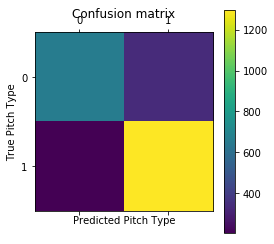

In [249]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True Pitch Type')
plt.xlabel('Predicted Pitch Type')
plt.show()
